Import Modules





Resources:

https://www.tensorflow.org/tutorials/images/classification#a_basic_keras_model

https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning

https://www.tensorflow.org/tutorials/images/data_augmentation#custom_data_augmentation

https://github.com/aswintechguy/Deep-Learning-Projects/blob/main/Dogs%20vs%20Cats%20Image%20Classification%20-%20CNN/Dogs%20vs%20Cats%20Image%20Classification%20-%20CNN.ipynb

https://www.tensorflow.org/tensorboard/get_started

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tensorflow as tf

from keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
warnings.filterwarnings('ignore')

Create Dataframe for Input and Output

In [3]:
input_path = []
label = []
data_dir = 'C:/Users/Johnny/My Drive/UNCC-Homework/Sem-8-Spring-2023-Grad/Machine-Learning/Project/Data'

for class_name in os.listdir("train"):
    for path in os.listdir("train/"+class_name):
        if class_name == 'A':
            label.append(0)
        if class_name == 'B':
            label.append(1)
        if class_name == 'C':
            label.append(2)
        if class_name == 'L':
            label.append(3)
        if class_name == 'Y':
            label.append(4)
        input_path.append(os.path.join("train", class_name, path))
# print(input_path[1000], label[1000])

In [4]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,train\cats\cat.2091.jpg,0
1,train\dogs\dog.1905.jpg,1
2,train\dogs\dog.5914.jpg,1
3,train\dogs\dog.1611.jpg,1
4,train\cats\cat.1312.jpg,0


Create the dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12500 files belonging to 2 classes.
Using 10000 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12500 files belonging to 2 classes.
Using 2500 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


Visualize the data

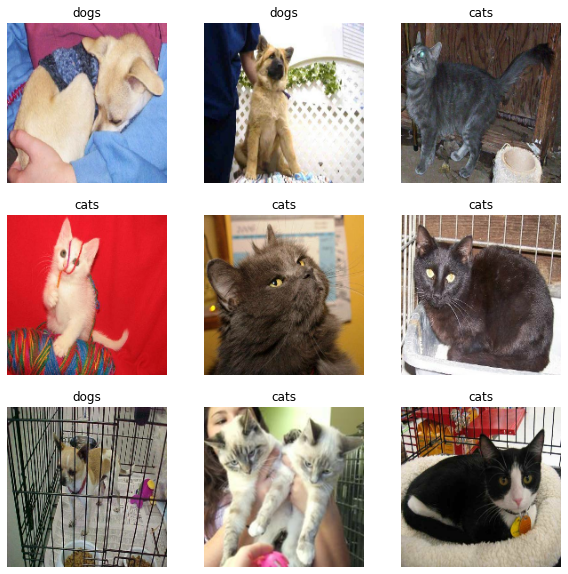

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Preformance, to keep data cached and ensure it isnt bottlenecked by dataset

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardized data

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.006431077 0.9609609


Data Augmentation

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

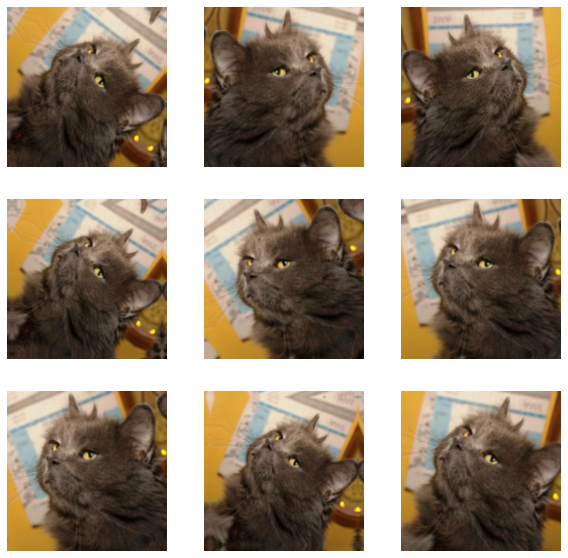

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
313/313 [==============================] - 80s 252ms/step - loss: 0.7086 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 2/20
313/313 [==============================] - 77s 247ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.4940
Epoch 3/20
313/313 [==============================] - 78s 249ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 4/20
313/313 [==============================] - 78s 248ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 5/20
313/313 [==============================] - 77s 247ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 6/20
313/313 [==============================] - 77s 246ms/step - loss: 0.6932 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 7/20
313/313 [==============================] - 77s 246ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6932 - val_ac

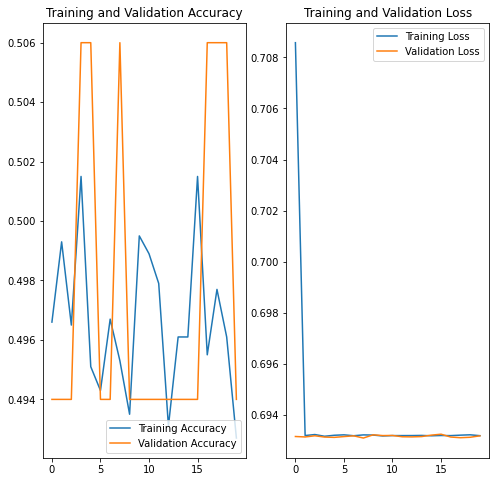

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Transfer learning : MobileNet V2

Data preprocessing

In [20]:
train_dir = 'C:/Applied-Artificial-Intelligence-ECGR-6119-001/train'
validation_dir = 'C:/Applied-Artificial-Intelligence-ECGR-6119-001/test'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [21]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 12500 files belonging to 2 classes.


In [22]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 12500 files belonging to 2 classes.


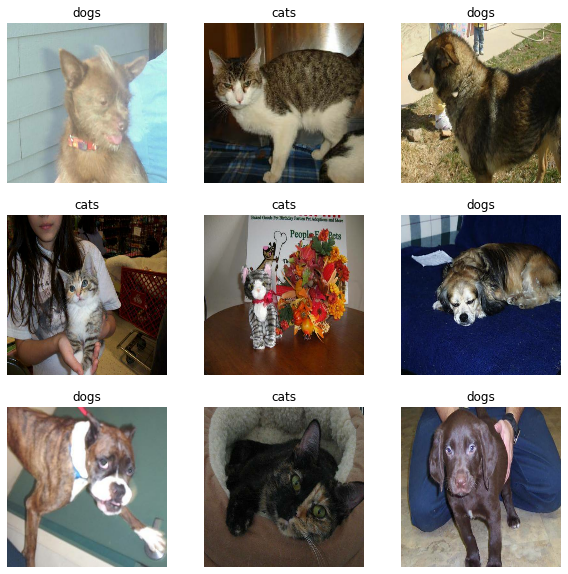

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 313
Number of test batches: 78


Configure the dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

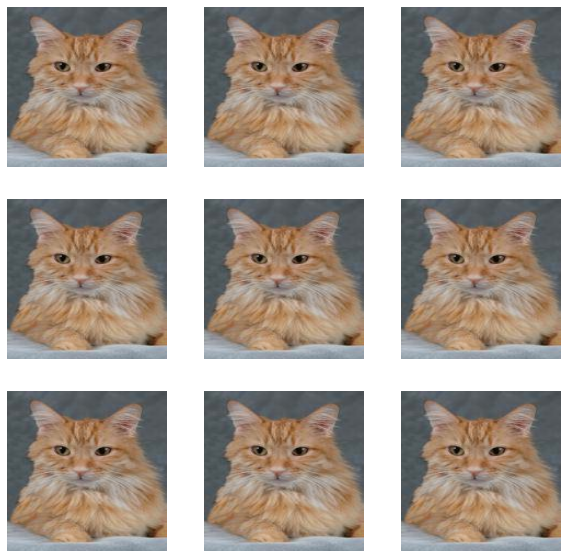

In [27]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel values

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [29]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained convnets

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature extraction : Freeze the convolutional base

In [32]:
base_model.trainable = False

In [33]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification head

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [36]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [39]:
len(model.trainable_variables)

2

Train the model

In [40]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

313/313 [==============================] - 58s 179ms/step - loss: 0.6927 - accuracy: 0.5933


In [41]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.59


In [42]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
391/391 [==============================] - 130s 328ms/step - loss: 0.4109 - accuracy: 0.7889 - val_loss: 0.1727 - val_accuracy: 0.9318
Epoch 2/10
391/391 [==============================] - 129s 331ms/step - loss: 0.2133 - accuracy: 0.9082 - val_loss: 0.1148 - val_accuracy: 0.9545
Epoch 3/10
391/391 [==============================] - 131s 335ms/step - loss: 0.1770 - accuracy: 0.9256 - val_loss: 0.0945 - val_accuracy: 0.9619
Epoch 4/10
391/391 [==============================] - 132s 337ms/step - loss: 0.1563 - accuracy: 0.9344 - val_loss: 0.0825 - val_accuracy: 0.9687
Epoch 5/10
391/391 [==============================] - 133s 340ms/step - loss: 0.1459 - accuracy: 0.9394 - val_loss: 0.0759 - val_accuracy: 0.9710
Epoch 6/10
391/391 [==============================] - 129s 331ms/step - loss: 0.1371 - accuracy: 0.9429 - val_loss: 0.0711 - val_accuracy: 0.9721
Epoch 7/10
391/391 [==============================] - 129s 331ms/step - loss: 0.1319 - accuracy: 0.9431 - val_loss: 0.0670 -

Learning curves

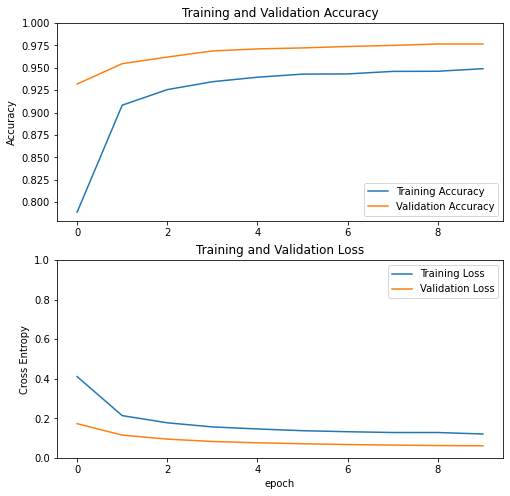

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning : Un-freeze the top layers of the model

In [44]:
base_model.trainable = True

In [45]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compile the model

In [46]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [48]:
len(model.trainable_variables)

56

Continue training the model

In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
391/391 [==============================] - 160s 403ms/step - loss: 0.1117 - accuracy: 0.9550 - val_loss: 0.0483 - val_accuracy: 0.9828
Epoch 11/20
391/391 [==============================] - 157s 401ms/step - loss: 0.0938 - accuracy: 0.9647 - val_loss: 0.0485 - val_accuracy: 0.9834
Epoch 12/20
391/391 [==============================] - 159s 408ms/step - loss: 0.0815 - accuracy: 0.9686 - val_loss: 0.0427 - val_accuracy: 0.9834
Epoch 13/20
391/391 [==============================] - 158s 405ms/step - loss: 0.0766 - accuracy: 0.9694 - val_loss: 0.0396 - val_accuracy: 0.9849
Epoch 14/20
391/391 [==============================] - 159s 407ms/step - loss: 0.0714 - accuracy: 0.9714 - val_loss: 0.0434 - val_accuracy: 0.9851
Epoch 15/20
391/391 [==============================] - 159s 406ms/step - loss: 0.0664 - accuracy: 0.9740 - val_loss: 0.0503 - val_accuracy: 0.9831
Epoch 16/20
391/391 [==============================] - 160s 409ms/step - loss: 0.0596 - accuracy: 0.9770 - val_loss: 0

In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

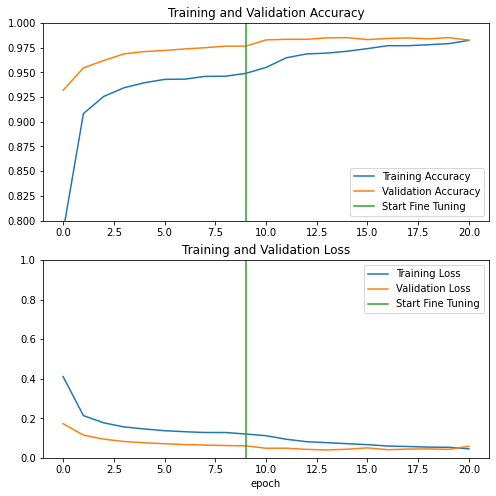

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

78/78 [==============================] - 13s 167ms/step - loss: 0.0605 - accuracy: 0.9828
Test accuracy : 0.9827724099159241


Predictions:
 [0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0]
Labels:
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0]


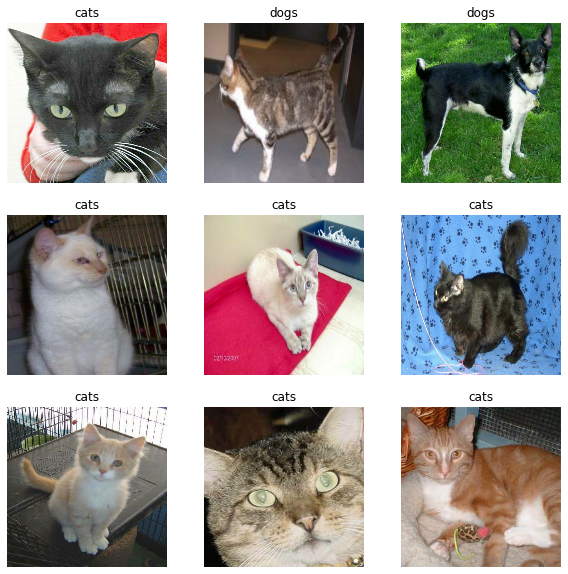

In [53]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [54]:
def ImageLoader(image):
    import random
    potato = random.randrange(0, 7, 1)
    if potato == 1:
        flipped = tf.image.flip_left_right(image)
    elif potato == 2:
        grayscaled = tf.image.rgb_to_grayscale(image)
    elif potato == 3:
        saturated = tf.image.adjust_saturation(image, 3)
    elif potato == 4:
        bright = tf.image.adjust_brightness(image, 0.4)
    elif potato == 5:
        cropped = tf.image.central_crop(image, central_fraction=0.5)
    elif potato == 6:
        rotated = tf.image.rot90(image)

In [61]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime

# Clear any logs from previous runs
# rm -rf ./logs/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2202 - accuracy: 0.9351 - val_loss: 0.1130 - val_accuracy: 0.9647
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0961 - accuracy: 0.9710 - val_loss: 0.0920 - val_accuracy: 0.9720
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0711 - accuracy: 0.9776 - val_loss: 0.0738 - val_accuracy: 0.9770
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.0749 - val_accuracy: 0.9771
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0433 - accuracy: 0.9857 - val_loss: 0.0778 - val_accuracy: 0.9754


In [63]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 9048), started 0:01:43 ago. (Use '!kill 9048' to kill it.)